In [1]:
# default_exp data

# Import

In [2]:
#export
import copy
import random
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from IPython.core.debugger import set_trace
from PIL import Image

# Config

In [3]:
dir_data = Path('data')

# Utility

In [4]:
#export
def torch2np(img): return img.permute(1,2,0).detach().cpu().numpy()

In [5]:
#export
def denorm(img): return (img*np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

# Dataloader

In [6]:
#export
class SubsetSampler(data.Sampler):
    def __init__(self, data_source, num_samples=None):
        self.data_source = data_source
        self.num_samples = num_samples if num_samples is not None else len(data_source)
        
    def __iter__(self):
        n = len(self.data_source)
        return iter(torch.randperm(n)[:self.num_samples].tolist())

    def __len__(self):
        return self.num_samples

In [7]:
#export
class SubsetDataloader(data.DataLoader):
    def __init__(self, dataset, num_samples=None, **kwargs):
        super().__init__(dataset, sampler=SubsetSampler(dataset, num_samples), **kwargs)

# Datasets

In [8]:
#export
class ImgCSVDataset(data.Dataset):
    def __init__(self, dir_imgs, file_csv, tfms=None):
        self.dir_imgs = dir_imgs
        self.tfms = tfms
        self.df = pd.read_csv(file_csv)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):    
        img = Image.open(self.dir_imgs/self.df.loc[idx, 'path']).convert('RGB')
                       
        if self.tfms is not None:
            img = self.tfms(img)
            
        return img, copy.deepcopy(img)

# Create train/validation split

In [7]:
dir_imgs = dir_data/'content'/'raw'
files_img = [f.name for f in dir_imgs.rglob('*') if f.is_file()]
random.shuffle(files_img)
idx_split = int(0.975*(len(files_img)-1))
files_trn, files_val = files_img[:idx_split], files_img[idx_split:]
df_trn, df_val = pd.DataFrame({'path': files_trn}), pd.DataFrame({'path': files_val})
file_trn, file_val = dir_data/'content'/'trn.csv', dir_data/'content'/'val.csv'
df_trn.to_csv(file_trn, index=False)
df_val.to_csv(file_val, index=False)

# Test

In [9]:
dir_imgs = dir_data/'content'/'formatted_256'
file_trn = dir_data/'content'/'trn.csv'

In [10]:
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])])

In [11]:
ds_trn = ImgCSVDataset(dir_imgs, file_trn, tfms=tfms)

In [12]:
batch_size = 4
num_workers = 4
pin_memory = False
num_samples = 10

dl_trn = SubsetDataloader(ds_trn, 
                          batch_size=batch_size,
                          num_workers=num_workers,
                          pin_memory=pin_memory,
                          num_samples=num_samples)

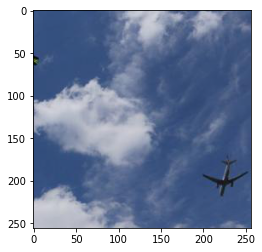

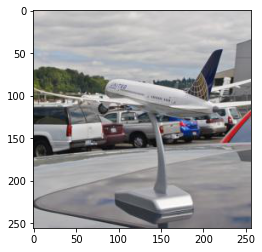

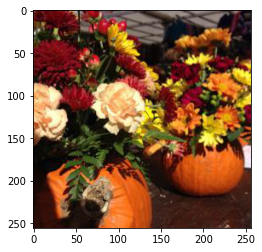

In [13]:
for idx, (X,y) in enumerate(dl_trn):
    plt.figure(idx)
    img = torch2np(X[0])
    plt.imshow(denorm(img))

# Build

In [14]:
!nbdev_build_lib

Converted data.ipynb.
Converted format_images.ipynb.
Converted models.ipynb.
